# XGBoost effect of providing background data to SHAP explainer
### Plain English summary

To look at the interaction of feature Year with Stroke team (as year is only selected in the feature list if stroke team an option too).

SHAP interactions can not be calculated for multiclass classification. Instead train binary models, converting the target feature (disability_discharge) into a binary feature by predicting one class vs the rest. Have seven models (predict mRS0 vs mRS1-6, predict mRS1 vs rest, predict mRS2 vs rest, predict mRS3 vs rest, predict mRS4 vs rest, predict mRS5 vs rest, predict mRS6 vs mRS0-5)  

Use just first kfold as seen performance of model is consistent across the 5 data divisions.

This model includes 7 features "prior_disability", "stroke_severity", "stroke_team", "age", "onset-to-thrombolysis-time", "any_afib_diagnosis", "precise_onset_known"]\
First k-fold\

### Model and data
XGBoost\
7 features: ["prior_disability", "stroke_severity", "stroke_team", "age", "onset-to-thrombolysis-time", "any_afib_diagnosis", "precise_onset_known"]\
First k-fold\

### Aims


### Observations




#### Further work

#### Resources
Using code from https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/02b_xgb_combined_fit_accuracy_key_features_separate_k_fold.ipynb

and https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/03_xgb_combined_shap_key_features.ipynb




## Import libraries

In [166]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import auc

from dataclasses import dataclass

import pickle
import shap

from os.path import exists

import math

import time
import datetime

Report the time duration to run notebook

In [167]:
start_time = time.time()

Use just the first k-fold split

In [168]:
k = 0

## Set up paths and filenames

For consistency, the folders end with "/" and the text for filenames include no trailing "_".

In [169]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    image_save_path: str = './saved_images'
    model_save_path: str = './saved_models'
    data_save_path: str = './saved_data'
    data_read_path: str = '../data_processing/output/kfold_5fold'
    model_text: str = f'xgb_all_features_5fold'
    notebook: str = '016'

paths = Paths()

Create output folders if needed

In [170]:
path = paths.image_save_path
if not os.path.exists(path):
    os.makedirs(path)
        
path = paths.model_save_path
if not os.path.exists(path):
    os.makedirs(path)

path = paths.data_save_path
if not os.path.exists(path):
    os.makedirs(path)

In [171]:
def drop_columns(df, cols):
    """
    For the dataframe, remove the columns 'cols' if they are present
    
    Args:
        df [dataframe]: The feature values per patient
        cols [list]: The features to remove if present

    Return:
        df [dataframe]: The feature values per patient without specified columns
    """
    for col in cols:
        if col in df.columns: df.drop([col],axis=1,inplace=True)
    return(df)

In [172]:
cols_remove = ['id','stroke_team_id']

## Import data

Import the first kfold split

In [173]:
filename = os.path.join(paths.data_read_path, 
                        ('03_train_' + str(k) + '.csv'))
train_data = pd.read_csv(filename)
#    train.rename(columns=dict_feature_name, inplace=True)
train_data = drop_columns(train_data, cols_remove)

filename = os.path.join(paths.data_read_path, 
                        ('03_test_' + str(k) + '.csv'))
test_data = pd.read_csv(filename)
#    test.rename(columns=dict_feature_name, inplace=True)
test_data = drop_columns(test_data, cols_remove)

In [174]:
feature_names = list(train_data)

### One hot the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [175]:
test_stroke_team = test_data["stroke_team"]

In [176]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    Converts a categorical feature into a one hot encoded feature
    
    Args:
        df [dataframe]: training or test dataset
        feature_name [str]: feature to convert to one hot encoding
        prefix [str]: string to use on new feature

    Return:
        df [dataframe]: One hot encoded representation of the feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Set up two lists for the one hot encoding. 

A list of the feature names that are categorical and to be converted using one hot encoding.
A list of the prefixes to use for these features.

In [177]:
features_to_one_hot = ["stroke_team", "weekday"]
list_prefix = ["team", "weekday"]

For each feature in the list, for each train and test dataset, convert to one hot encoded.

In [178]:
for feature, prefix in zip(features_to_one_hot, list_prefix):
    if feature in feature_names:
        train_data = (
            convert_feature_to_one_hot(train_data, feature, prefix))
        test_data = (
            convert_feature_to_one_hot(test_data, feature, prefix))

In [179]:
feature_names_ohe = list(train_data)
feature_names_ohe.remove("discharge_disability")
n_features = len(feature_names_ohe)
print(f"There are {len(feature_names)} original features (before one-hot encoding)")
print(f"There are {n_features} features (after one-hot encoding)")

There are 55 original features (before one-hot encoding)
There are 177 features (after one-hot encoding)


Create function to return X and y data for train and test sets

In [180]:
def get_x_y_data(train, test, target):
    """
    Pass data from the split and return the dataframes with the target in one 
    dataframe (X), and dependent features in another (y)
    
    train (dataframe): dataframe containing training instances 
    test (dataframe): dataframe containing test instances
    target (string): column name of the targert feature (the column to separate from the two dataframes)
    """    

    # Get X and y
    X_train = train.drop(target, axis=1)
    X_test = test.drop(target, axis=1)
    y_train = train[target]
    y_test = test[target]

    return(X_train, X_test, y_train, y_test)

In [181]:
# Get k fold split
(X_train, X_test, y_train, y_test) = get_x_y_data(train_data,
                                                    test_data,
                                                    'discharge_disability')


Load XGBoost model from the first kfold (from notebook 010)

In [182]:
# Model filename
filename = os.path.join(paths.model_save_path, 
                        (f'010_xgb_all_features_5fold_{k}.p'))

# Check if exists
file_exists = exists(filename)

if file_exists:
# Load models
    with open(filename, 'rb') as filehandler:
        model = pickle.load(filehandler)
else:
    print('Run notebook 010 first. Using the model that was trained there')

Use model to predict disability at discharge

In [183]:
y_probs = model.predict_proba(X_test)
y_pred = model.predict(X_test)

Concentrate on just the probability for being mRS6 (as this multiclass model has a probability for each of the classes, and the prediction is the one with the highest probability)

In [184]:
mRS6 = 6

### SHAP values
SHAP values give the contribution that each feature has on the models prediction, per instance. A SHAP value is returned for each feature, for each instance.

We will use the shap library: https://shap.readthedocs.io/en/latest/index.html

'Raw' SHAP values from XGBoost model are log odds ratios. A SHAP value is returned for each feature, for each instance, for each model (one per k-fold)

TreeExplainer is a fast and exact method to estimate SHAP values for tree models and ensembles of trees. Using this we can calculate the SHAP values.

Either load from pickle (if file exists), or calculate.

Load SHAP with background data

In [185]:
# Set filename
filename = os.path.join(paths.data_save_path, 
                        (f'011_xgb_all_features_5fold_shap_values_extended_{k}.p'))
# Check if exists
file_exists = exists(filename)

if file_exists:
    # Load explainer
    with open(filename, 'rb') as filehandler:
        shap_values_extended = pickle.load(filehandler)
        shap_values = shap_values_extended.values
else:
    print("Run notebook 011, that calculates the SHAP values with background data")

Calculate (or load) SHAP without background data

In [186]:
# Set filename

filename = os.path.join(paths.data_save_path,
                        (paths.notebook + '_' + paths.model_text + 
                         f'_shap_values_extended_wo_background_{k}.p'))

filename_explainer_wo_background = os.path.join(paths.data_save_path,
                        (paths.notebook + '_' + paths.model_text + 
                         f'_shap_explainer_wo_background_{k}.p'))

# Check if exists
file_exists = exists(filename)

if file_exists:
    # Load explainer
    with open(filename, 'rb') as filehandler:
        shap_values_extended_wo_background = pickle.load(filehandler)
        shap_values_wo_background = shap_values_extended_wo_background.values

    # Load explainer
    with open(filename_explainer_wo_background, 'rb') as filehandler:
        explainer_wo_background = pickle.load(filehandler)

else:
    # Calculate SHAP values

    # Set up explainer using the model and feature values from training set
    explainer_wo_background = shap.TreeExplainer(model)

    # Get (and store) Shapley values along with base and feature values
    # check_additivity=False allows the sum of SHAP to not equal the model output.
    # Without this, get error that one of the instances has the sum of the SHAP values 3.658020, while the model output was 0.401079.
    shap_values_extended_wo_background = explainer_wo_background(X_test)#, 
#                                                  check_additivity=False)
    
    # Shap values exist for each classification in a Tree
    # We are interested in 1=give thrombolysis (not 0=not give thrombolysis)
    shap_values_wo_background = shap_values_extended_wo_background.values

    # Save explainer using pickle
    with open(filename_explainer_wo_background, 'wb') as filehandler:
        pickle.dump(explainer_wo_background, filehandler)
        
    # Save shap values extendedr using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(shap_values_extended_wo_background, filehandler)

#### Look at the difference between the two SHAP values and the model output

Create function to calculate probability from log odds

In [187]:
def logodds_to_prob(logodds):
    """
    Privdie logodds, return equivalent in probability

    Args:
        logodds [float]: log odd value
    Return:
        prob [float]: probability value
    """
    odds = np.exp(logodds)
    prob = odds / (1 + odds)
    return(prob)

Create three subplots:
subplot 1) model probability vs shap values with background data
subplot 2) model probability vs shap values without background data
subplot 3) shap values with background data vs shap values without background data

Text(0, 0.5, 'Shap values (without background data)')

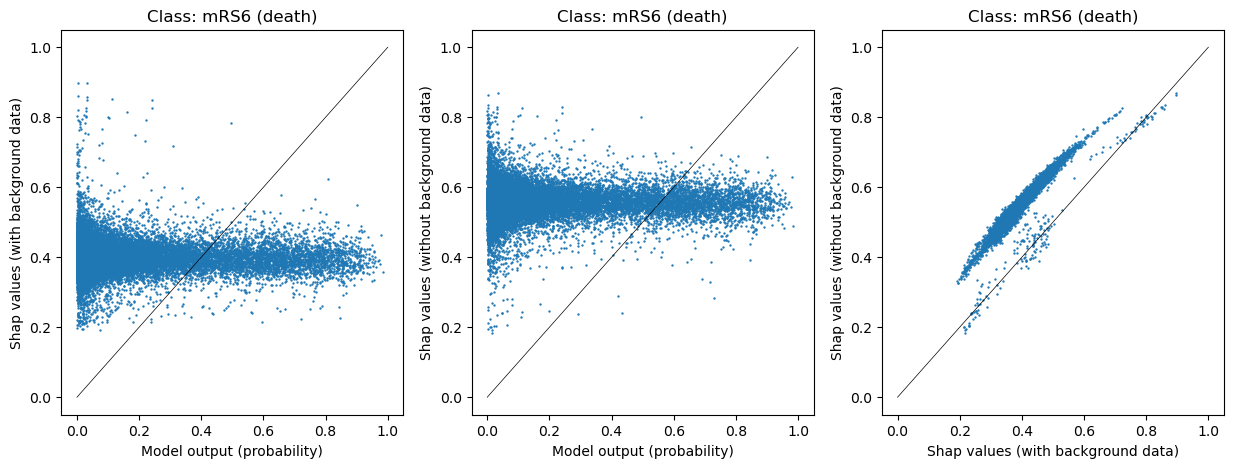

In [188]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

shap_prob_mrs6_background = (
    logodds_to_prob(shap_values_extended[:,:,mRS6].base_values + 
                    shap_values[:,mRS6].sum(axis=1)))

shap_prob_mrs6_wo_background = (
    logodds_to_prob(shap_values_extended_wo_background[:,:,mRS6].base_values + 
                    shap_values_wo_background[:,mRS6].sum(axis=1)))

ax=axs[0]
ax.plot(np.array([0,1]),np.array([0,1]),color='k', linewidth=0.5)
ax.scatter(y_probs[:,mRS6], shap_prob_mrs6_background, s=0.5)
ax.set_title("Class: mRS6 (death)")
ax.set_xlabel("Model output (probability)")
ax.set_ylabel("Shap values (with background data)")

ax=axs[1]
ax.plot(np.array([0,1]),np.array([0,1]),color='k', linewidth=0.5)
ax.scatter(y_probs[:,mRS6], shap_prob_mrs6_wo_background, s=0.5)
ax.set_title("Class: mRS6 (death)")
ax.set_xlabel("Model output (probability)")
ax.set_ylabel("Shap values (without background data)")

ax=axs[2]
ax.plot(np.array([0,1]),np.array([0,1]),color='k', linewidth=0.5)
ax.scatter(shap_prob_mrs6_background, shap_prob_mrs6_wo_background, s=0.5)
ax.set_title("Class: mRS6 (death)")
ax.set_xlabel("Shap values (with background data)")
ax.set_ylabel("Shap values (without background data)")

Create function to create a dataframe 

In [189]:
def create_df_one_hot_encoded_hosp_features(shap_values, 
                hospital_columns_index, hospital_names):
    """
    
    Args:
        shap_values []:
        hospital_columns_index []:
        hospital_names []:

    Return:
        df [dataframe]:
    """

    # Use this index list to access the hosptial shap values (as array)
    hosp_shap_values = shap_values[:,hospital_columns_index]

    # Put in dataframe with hospital as column title
    df = pd.DataFrame(hosp_shap_values, columns = hospital_names)

    return(df)

In [190]:
def add_columns_to_df(df, stroke_team_values):
    """
    Add these columns to the provided dataframe (and return):
    * Stroke team instance attended
    * contribution from all the hospital features
    * contribution from attending the hospital
    * contribution from not attending the rest
        
    Args:
        df [dataframe]:
        stroke_team_values []:

    Return:
        df [dataframe]:
    """

    # Include Stroke team that each instance attended
    df["Stroke team"] = stroke_team_values

    # Store the sum of the SHAP values (for all of the hospital features)
    df["all_stroke_teams"] = (df.sum(axis=1))

    # Initialise lists for 
    #   1) SHAP value for attended hospital 
    #   2) SHAP value for the sum of the rest of the hospitals
    attended_hospital = []
    not_attend_these_hospitals = []

    # For each patient
    for index, row in df.iterrows():

        # Get stroke team attended
        stroke_team = row["Stroke team"]
        
        # Get SHAP value for the stroke team attended
        attended_hospital.append(row[stroke_team])

        # Calculate sum of SHAP values for the stroke teams not attend 
        sum_rest = row["all_stroke_teams"] - row[stroke_team]
        not_attend_these_hospitals.append(sum_rest)

    # Store two new columns in dataframe
    df["attended_stroke_team"] = attended_hospital
    df["not_attended_stroke_teams"] = (not_attend_these_hospitals)
                    
    # View preview
    return(df)

In [191]:
# Get list of hospital one hot encoded column titles
hospital_names_ohe = X_test.filter(regex='^team',axis=1).columns
n_hospitals = len(hospital_names_ohe)

# Get list of hospital names without the prefix "team_"
hospital_names = [h[5:] for h in hospital_names_ohe]

# Create list of column index for these hospital column titles
hospital_columns_index = [X_test.columns.get_loc(col) for col in hospital_names_ohe]

# Create dictionary of column index for these hospital column titles
dict_hosp_index={}
for col in hospital_names_ohe:
    dict_hosp_index[f"{col}"] = X_test.columns.get_loc(col)

In [192]:
df_hosp_shap_values_wo_background = create_df_one_hot_encoded_hosp_features(
                    shap_values_wo_background[:, :, mRS6], hospital_columns_index, 
                    hospital_names)
df_hosp_shap_values_wo_background = add_columns_to_df(
                        df_hosp_shap_values_wo_background, 
                        test_stroke_team.values)

In [193]:
df_hosp_shap_values_wo_background.head()

,Addenbrooke's Hospital,Basildon University Hospital,Blackpool Victoria Hospital,Bradford and Airedale SU,Bronglais Hospital,Broomfield Hospital,Calderdale Royal Hospital,Charing Cross Hospital HASU,Chesterfield Royal,Colchester General Hospital,...,Worcestershire Royal Hospital,Worthing Hospital,Wycombe General Hospital,Yeovil District Hospital,York Hospital,Ysbyty Gwynedd,Stroke team,all_stroke_teams,attended_stroke_team,not_attended_stroke_teams
0,0.000522,-0.001515,0.000083,0.001422,0.013849,-0.000486,-0.001694,-0.000679,-0.000959,-0.000164,...,-0.001985,0.004361,0.000182,-0.001939,0.004102,0.000086,Bronglais Hospital,0.002700,0.013849,-0.011150
1,0.000358,-0.004307,0.000137,0.000434,-0.000026,-0.000717,-0.002022,-0.000432,-0.000882,-0.000158,...,-0.001432,0.004113,0.000175,-0.000828,0.001132,-0.000117,William Harvey Hospital,-0.062210,-0.034244,-0.027966
2,-0.000217,-0.006206,0.000083,0.001659,-0.000043,-0.002856,-0.001200,-0.000403,-0.000265,-0.000045,...,-0.001683,0.004874,0.000212,-0.000081,0.003876,-0.000060,Prince Charles Hospital,-0.061099,-0.035206,-0.025893
3,0.000529,-0.001532,0.000058,0.001708,-0.000090,-0.001154,-0.002051,-0.000527,0.000223,-0.000173,...,-0.001088,0.002186,0.000155,-0.001078,0.004612,-0.000053,Cumberland Infirmary,0.025741,0.060304,-0.034563
4,-0.000920,-0.003936,0.000137,0.001570,-0.000090,-0.003950,-0.002348,-0.000425,0.000434,-0.000469,...,-0.000144,0.004340,0.000282,0.000131,0.003593,-0.000060,University Hospitals of North Tees and Hartlepool,-0.070662,-0.034455,-0.036208


## Violin plots for SHAP values vs feature values (and a histogram for stroke team feature)

Column per SHAP (with and without background data for the creation of the SHAP explainer)

In [194]:
def set_ax(ax, category_list, feat, rotation=0):
    '''
    ax [matplotlib axis object] = matplotlib axis object
    category_list [list] = used for the xtick labels (the grouping of the data)
    feat [string] = used in the axis label, the feature that is being plotted
    rotation [integer] = xtick label rotation

    reeturn [matplotlib axis object]
    
    resource: 
    https://matplotlib.org/3.1.0/gallery/statistics/customized_violin.html
    '''
    # Set the axes ranges and axes labels
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(category_list) + 1))
    ax.set_xticklabels(category_list, rotation=rotation, fontsize=7)
    ax.set_xlim(0.25, len(category_list) + 0.75)
    ax.set_ylabel(f'SHAP values for {feat}', fontsize=12)
    ax.set_xlabel(f'Feature values for {feat}', fontsize=12)
    return(ax)

In [195]:
def set_each_subplot_same_range_per_row(fig, r, c):
    if c > 1:
        axs = fig.axes
        # Adjust the subplots
        for row in range(r):
            y_min = 999
            y_max = -999  
            # Through each subplot in this row (through columns)
            for col in range(c):
                ax = axs[(row * c) + col]
                y_min = min(y_min,ax.get_ylim()[0])
                y_max = max(y_max,ax.get_ylim()[1])
            for col in range(c):
                ax = axs[(row * c) + col]
                ax.set_ylim(y_min, y_max)

    return(fig)

In [200]:
def violin_plots_compare_models(class_category,
                                list_violin_features, 
                                list_shap_values_extended,
                                list_title,
                                n_features_show=6,
                                equal_steps=True):

    # Feature Age needs special consideration. It needs the x ticks to be created,
    # as the other features with over 50 unique values, but age is already grouped 
    # for the model (into 5yr groups) and so is treated as the other type.

    # figure height depends on number of features, width on number of models
    #max_features = len(max(list_violin_features, key = lambda i: len(i)))
    #height = 7 * max_features
    height = 7 * n_features_show
    n_models = len(list_title)
    width = 6 * n_models

    # Determine number of rows of subplots by rounding up
    ncols = n_models
    nrows = n_features_show#max_features

    # Create figure
    # "squeeze=False": forces a 2D axs return (even if only one row or column)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(width,height), 
                            squeeze=False)
    fig.suptitle(
            f'Model to predict discharge disability mRS = {class_category}', 
            fontsize=20)

    # A subplot showing violin plot for a feature, from dfferent models.
    # First prepare the fature data for the violin plot: if feature has more than 
    # 50 unique values then assume it needs to be binned (a violin for each bin)

    # Comparing n models (a column of subplots per model)
    for m in range(n_models):
        features_violin = list_violin_features[m][:n_features_show]
        shap_values_extended = list_shap_values_extended[m]

        # Through each feature
        for n, feat in enumerate(features_violin):   
            #subplot = ((n_models*n)+i)+1
            
            # Get data and SHAP values
            feature_data = shap_values_extended[:, feat, class_category].data
            feature_shap = shap_values_extended[:, feat, class_category].values

            # If feature has more that 50 unique values, then assume it needs
            #  to be binned (otherwise assume they are unique categories)

            if np.unique(feature_data).shape[0] > 50:
                # bin the data, create a violin per bin
                
                # settings for the plot
                rotation = 45

                if ((feat == "onset_to_thrombolysis_time") or 
                    (feat == "scan_to_thrombolysis_time")):
                    value_without_negative = np.delete(
                                feature_data, np.where(feature_data == -100))
                    if equal_steps == True:
                        np.min(value_without_negative)
                        np.max(value_without_negative)
                        step = 0.10
                        # Using np.round() and tolist() to force the values to 
                        # be floats with 1dp
                        bins = np.round(
                                np.arange(
                                 np.min(value_without_negative), 
                                 np.max(value_without_negative), 
                                 step * (np.max(value_without_negative) - np.min(value_without_negative)))
                                ,1)
                    else:
                        # Equal count
                        (res, bins) = pd.qcut(value_without_negative, q=10, 
                                              retbins=True)

                    bin_list = bins.tolist()
                    # for -100 for no IVT
                    bin_list.insert(0, feature_data.min())
                    n_bins = len(bin_list)-2
                else:

                    step = 30
                    n_bins = min(11, np.int((feature_data.max())/step))
                    
                    # create list of bin values
                    bin_list = [(i*step) for i in range(n_bins)]
                    bin_list.append(feature_data.max())

                # Number of instances per bin
                counts, edges = np.histogram(feature_data, bins=bin_list, 
                                             density=False)

                # create list of bins (the unique categories)
                category_list = [f'{int(bin_list[i+1])}-{int(bin_list[i+2])}\n[n={int(counts[i+1])}]' for i in range(n_bins-1)]
                category_list.append(f'{int(bin_list[-2])}+\n[n={int(counts[-1])}]')
                if (feat == "onset_to_thrombolysis_time") or (feat == "scan_to_thrombolysis_time"):
                    # for -100 for no IVT
                    category_list.insert(0, f'Not receive IVT\n[n={int(counts[0])}]')

                # bin the feature data
                feature_data = pd.cut(feature_data, bin_list, labels=category_list, 
                                        right=False)

                # create a list, each entry contains the corresponsing SHAP 
                # value for that category (or bin). A violin will represent each 
                # list.    
                shap_per_category = []
                for category in category_list:
                    mask = feature_data == category
                    shap_per_category.append(feature_shap[mask])

            else:
                # create a violin per unique value
                
                # settings for the plot
                rotation = 90
                
                # create list of unique categories in the feature data
                category_list = np.unique(feature_data)

                # Age needs to keep its decimal value (midpoint between 5 yrs)
                if feat != 'age':
                    # category_list = [int(i) for i in category_list]
                    # Account for nan in the NIHSS features (ignore and include them)
                    category_list = [int(i) if not np.isnan(i) else i for i in category_list]
                    # Account for nan in the NIHSS features (ignore and exclude them)
                    # category_list = [int(i) for i in category_list if not np.isnan(i)]
                    
                # create a list, each entry contains the corresponsing SHAP value for that 
                # category (or bin). A violin will represent each list.    
                count = []
                shap_per_category = []
                for category in category_list:
                    mask = feature_data == category
                    shap_per_category.append(feature_shap[mask])
                    count.append(mask.sum())

                if feat == 'age':
                    # create text of x ticks
                    category_list = [f'{int(i-2.5)}-{int(i+2.5)}' for 
                                                        i in category_list]

                    # SSNAP dataset had oldest age category as 100-120 (not a 5 yr band as 
                    #   the other ages). To accommodate this, if last age category is "110"
                    #   then overwrite the label with the correct band (100-120), and not
                    #   107-112 as the above code would create.
                    if category_list[-1] == '107-112':
                        category_list[-1] = '100-120'
                if feat == 'stroke_severity':
                    # not enough space of chart for 2 lines fo x tick labels
                    category_list = [f'{category_list[i]} [n={count[i]}]' for 
                                                i in range(len(category_list))]
                else:
                    category_list = [f'{category_list[i]}\n[n={count[i]}]' for 
                                                i in range(len(category_list))]

            # create violin plot
            ax = axs[n][m]
            nans = [float('nan'), float('nan')]
            # For the case where there is an empty array for a violin
            ax.violinplot([val if val.any() else nans for val in shap_per_category],
                            showmeans=True, widths=0.9)

            # Add line at Shap = 0
            feature_values = shap_values_extended[:, feat].data
            ax.plot([0, len(feature_values)], [0,0],c='0.5')   

            # customise the axes
            ax = set_ax(ax, category_list, feat, rotation=rotation)
            plt.subplots_adjust(bottom=0.15, wspace=0.05)

            # Adjust stroke severity tickmarks
            if feat == 'Stroke severity':
                ax.set_xticks(np.arange(1, len(category_list)+1, 2))
                ax.set_xticklabels(category_list[0::2])   
                
            # Add title
            ax.set_title(f'{list_title[m]} \n Feature: {feat} \n Class: mRS{class_category}')

    # Subplots on same row have same y range
    fig = set_each_subplot_same_range_per_row(fig, nrows, ncols)

    space_for_suptitle = 1 - (n_features_show * 0.005/5)
    plt.tight_layout(pad=2, rect=[0, 0, 1, space_for_suptitle])
        
    filename = os.path.join(paths.image_save_path, (paths.notebook + 
                            paths.model_text + 
                            f'_shap_violin_class_{class_category}.jpg'))
    
    fig.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.2)

    plt.show()
    return()

In [197]:
def histograms_compare_models(class_category,
                              list_unique_team_feature_names,
                              list_shap_values_extended,
                              list_title):

    dp = 3
    # figure height depends on number of features, width on number of models
    n_models = len(list_title)
    width = 5.8 * n_models

    nrows = 1
    ncols = n_models
    # Create figure
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(width,6.5), 
                            constrained_layout=True)

    fig.suptitle(
            f'Model to predict discharge disability at least as well as mRS = {class_category}', 
            fontsize=20)

    # histogram for stroke team SHAP for an output category, comparing models

    # First prepare the feature data

    # Comparing n models (a column of subplots per model)
    for m in range(n_models):
        
        shap_values_extended = list_shap_values_extended[m]

#        feature_names_ohe = list(feature_data.columns)
        list_unique_stroketeams = list_unique_team_feature_names[m]

        # Get mean SHAP for stroke team when patient attending that stroke team
        stroke_team_mean_shap = []

        # If there are stroke teams
        if len(list_unique_stroketeams) > 0:
            # Loop through feature names
            for feature_name in list_unique_stroketeams:
                # Use the data column for team name as a mask for patients that attend the team (the data will be the same for all class_categories)
                mask = shap_values_extended[:, feature_name].data == 1
                # Use make to get the SHAP values for the stroke team, for the patients that attend this team
                stroke_team_shap = shap_values_extended[:, feature_name].values[mask]
                # Get mean
                mean_shap = np.mean(stroke_team_shap)
                # Store mean
                stroke_team_mean_shap.append(mean_shap)
            if n_models == 1:
                ax = axs                
            else:
                ax = axs[m]

            ax.hist(stroke_team_mean_shap, 
                    color=[0.12156863, 0.46666667, 0.70588235, 0.3], 
                    ec=[0.12156863, 0.46666667, 0.70588235, 1.], 
                    linewidth=1.4)#, bins=np.arange(-1.5, 1.5, 0.1)

            ax.set_xlabel('SHAP values for hospital attended')
            ax.set_ylabel('Count')

            # Add title
            ax.set_title(f'{list_title[m]} \n Feature: stroke team \n Class: mRS{class_category}')


            text =('\n'.join((
                f'Mean: {round(np.mean(stroke_team_mean_shap),dp)}',
                f'Standard deviation '
                f'{round(np.std(stroke_team_mean_shap),dp)}')))

            # place a text box in upper left in axes coords
            props = dict(boxstyle='round', facecolor='grey', alpha=0.2)
            ax.text(0, (-0.15), text, 
                    transform=ax.transAxes, fontsize=10, 
                    verticalalignment='top', bbox=props)


    # Subplots on same row have same y range
    fig = set_each_subplot_same_range_per_row(fig, nrows, ncols)

    filename = os.path.join(paths.image_save_path, (paths.notebook + 
                            paths.model_text + '_hosp_shap_hist.jpg'))
    
    plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.2)

    plt.show()

    range_shap_log_odds = max(stroke_team_mean_shap) - min(stroke_team_mean_shap)
    odds = math.exp(range_shap_log_odds)
    print(f"There was a {round(odds,2)} fold difference in odds of being "
          f"classified as mRS{class_category} between hospitals")
    
    return()

In [198]:
# Get list of features (a list per model) [exclude the target feature]
list_model_features_wo_teams = []
list_model_features = []
list_unique_team_feature_names = []

# Get column names from the models test dataset
model_features = list(test_data)

# Remove target feature
model_features.remove("discharge_disability")

# Store for use in histograms
list_model_features.append(model_features)
list_model_features.append(model_features)

# Create a mask for feature names that don't contain string "team_"
mask_exclude_team = ['team_' not in i for i in model_features]
mask_include_team = ['team_' in i for i in model_features]

# Use mask to exclude features containing string "team_"
model_features = np.array(model_features)
model_features_wo_teams = model_features[mask_exclude_team]
model_team_features = model_features[mask_include_team]
#    model_features = model_features.tolist()

# Store for use below
list_model_features_wo_teams.append(model_features_wo_teams.tolist())
list_model_features_wo_teams.append(model_features_wo_teams.tolist())
list_unique_team_feature_names.append(model_team_features.tolist())
list_unique_team_feature_names.append(model_team_features.tolist())

list_model_title = []
list_model_title.append(f"Predicting probability of patients disability at "
                        f"discharge being mRS6\n(with background data)")
list_model_title.append(f"Predicting probability of patients disability at "
                        f"discharge being mRS6\n(without background data)")

list_shap_values_extended = []
list_shap_values_extended.append(shap_values_extended)
list_shap_values_extended.append(shap_values_extended_wo_background)

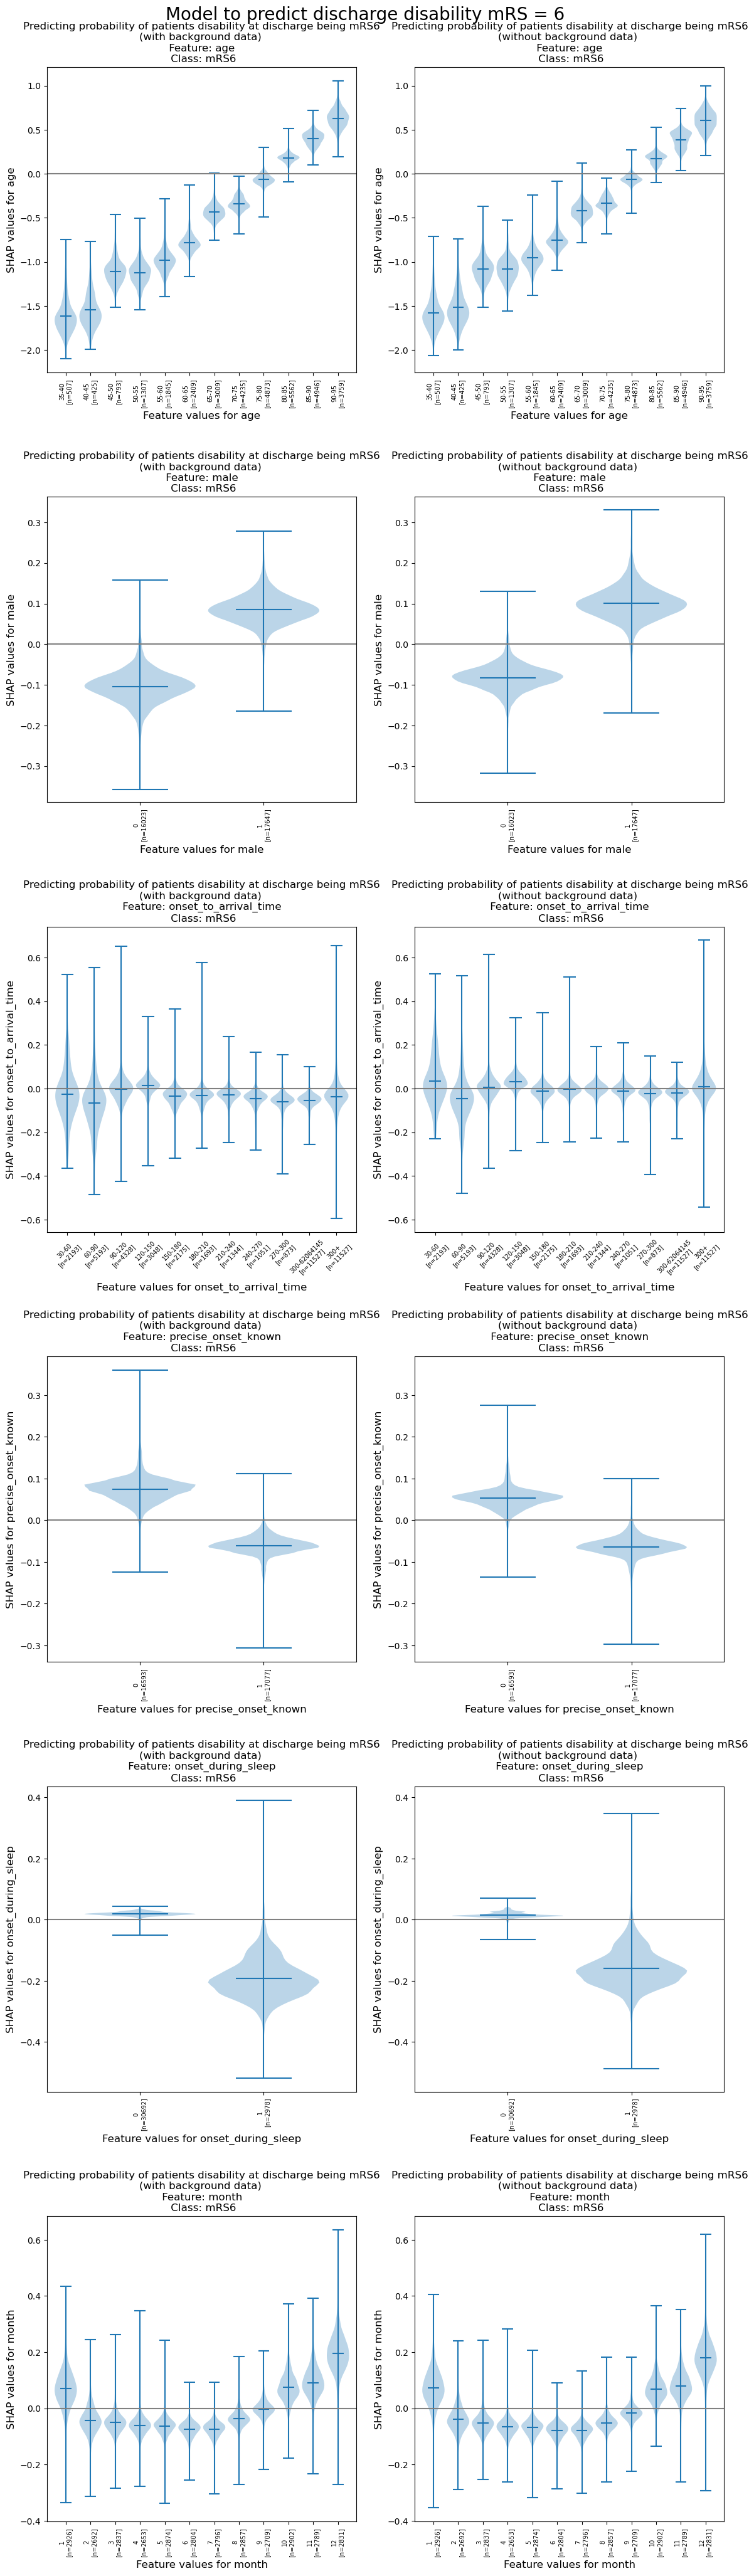

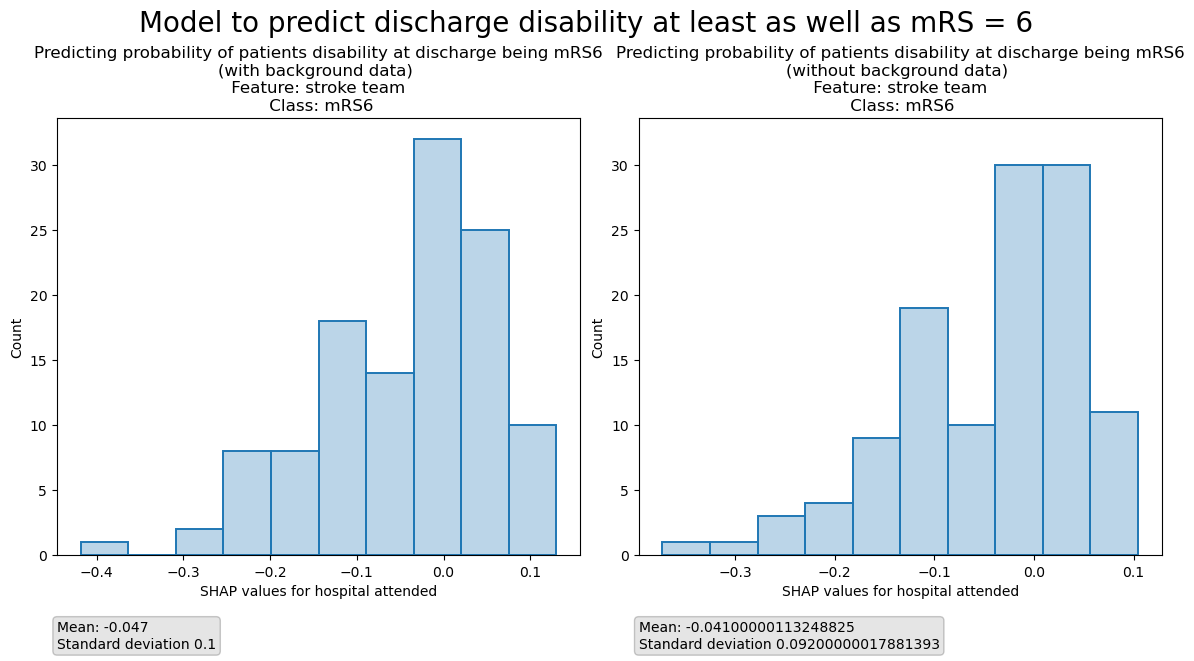

There was a 1.61 fold difference in odds of being classified as mRS6 between hospitals


()

In [201]:
# Violin plots of feature data vs SHAP values
violin_plots_compare_models(mRS6,
                            list_model_features_wo_teams, 
                            list_shap_values_extended,
                            list_model_title,
                            n_features_show=6,
                            equal_steps=False)

# Histogram of stroke team SHAP values
histograms_compare_models(mRS6,
                          list_unique_team_feature_names,
                          list_shap_values_extended,
                          list_model_title)

Duration to run notebook

In [ ]:
str(datetime.timedelta(seconds=(time.time()-start_time)))

'0:00:22.293871'